In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import math
import keras.backend as K
from keras.models import load_model
import json
import datetime
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

DATA_SHAPE = 224
GPU_MEMORY_FRACTION = 1.0
TIMEFORMAT = "%m-%d-%H:%M:%S"

def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction
    sess = tf.Session(config=config)
    K.set_session(sess)

config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('/home/mc16/model3/unet0615.h5')
val_images = np.load('/home/mc16/pre_data/val_image.npy')
val_labels = np.load('/home/mc16/pre_data/val_label_w3.npy')
test1_images = np.load('/home/mc16/pre_data/test1_image.npy')

Using TensorFlow backend.
/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Seg

In [3]:
def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]

# CRF

In [4]:
from keras.preprocessing import image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax
import warnings
warnings.simplefilter("ignore", np.RankWarning)

def crf_image(img, model, gdims=(2,3), bdims=(20,100), iteras=1):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))

    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    unary = unary_from_softmax(softmax)
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    feats = create_pairwise_gaussian(sdims=gdims, shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_bilateral(sdims=bdims, schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = crf.inference(iteras)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res

def cut_shit(mask, num, frac=0.7):
    cut_mask = np.array(mask)
    for j in range(224):
        for i in range(223-num):
            if np.sum(cut_mask[j, i:i+num]) > num*frac:
                cut_L = i + int(num * (1 - frac * 0.9))
                cut_R = i + int(num * (1 - frac * 0.1))
                cut_mask[j, cut_L:cut_R] = 0
                i = cut_R
    return cut_mask

def cut_top(mask, thresh, frac=0.04):
    cut_mask = np.array(mask)
    sum_mask = np.sum(mask, axis=1)
    top_index = 0
    for i in range(len(sum_mask)):
        if sum_mask[i] > thresh:
            top_index = i
            break
    cut_index = top_index + int((224 - top_index) * frac)
    cut_mask[:cut_index,:] = 0
    return cut_mask, top_index

# Cluster

In [5]:
from sklearn.cluster import DBSCAN

def matrix_to_point(matrix):
    points = []
    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if(matrix[x][y] == 1):
                points.append([x, y])
    return np.array(points, dtype=np.uint8)

def get_clusters(points, EPS = 1.5, MIN_SAMPLES = 3, minN=20, RANGE = 20):
    if len(points) == 0: 
        cluster_list = []
    else:
        arpoints = np.array(points, dtype=np.uint8)
        cluster_label = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(arpoints)
        max_label = np.max(cluster_label)
        min_label = np.min(cluster_label)
#         print("lines number: %s"%(max_label-min_label+1))
        cluster_list = []
        for label in range(min_label, max_label+1):
            label_index = np.where(cluster_label == label)
            if(len(label_index[0]) > minN):
                temp_cluster = arpoints[label_index]                
                x = temp_cluster[:, 0]
                y = temp_cluster[:, 1]
                x_range = x.max() - x.min()
                y_range = y.max() - y.min()
#                 if x_range > RANGE or y_range > RANGE: 
#                 print(max(x_range, y_range))
                if max(x_range, y_range) > RANGE:
                    cluster_list.append(temp_cluster)
    return np.array(cluster_list)

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
            pic[point[0], point[1]] = 50 + i * int((255 - 50) / num_label) 
    return pic

# Fit

In [6]:
def get_line_info(points):
    ## 得到符合条件的line, line_info
    ## 返回points, line_info_right, line_info_polar
    line_info_right = []
    line_info_polar = []
    for line_num in range(points.shape[0]):
        x = points[line_num][:, 0]
        y = points[line_num][:, 1] 
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        line_info_right.append(z)
        z_j = z.copy()
        z_j[0] = (math.atan(z_j[0]) * 180 / math.pi) - 90
        z_j[1] = abs(z_j[1] * math.sin(z_j[0]))
        line_info_polar.append(z_j)
    return points, line_info_right, line_info_polar

## 根据传入的每条线的极坐标参数，角度阈值，距离阈值，将符合条件的簇删掉（todo 合并）
def get_flg_arr(line_info_polar, ANGEL = 20, DIS = 50):
    flg = [0 for i in range(len(line_info_polar))]
    flg_id = 1
    i = 0
    while i < line_info_polar.__len__():
        if flg[i] == 0:
            flg[i] = flg_id
            flg_id += 1
        else:
            i += 1
            continue
        j = i + 1
        while(j < line_info_polar.__len__()):
            if flg[j] != 0:
                j += 1
                continue
            
            if abs(line_info_polar[i][0] - line_info_polar[j][0]) < ANGEL and abs(line_info_polar[i][1] - line_info_polar[j][1]) < DIS:
#                 print(i, j, abs(line_info_polar[i][0] - line_info_polar[j][0]), abs(line_info_polar[i][1] - line_info_polar[j][1]))
                flg[j] = flg[i]
            j += 1
        i += 1
    return flg

# input struct line -> point
def get_better_line_per_sample(points, x_min, ANGEL=20, DIS=50):
    line_list = []
    if(len(points)==0):
        return line_list
        
    x_min_mean = x_min
    new_points, line_info_right, line_info_polar = get_line_info(points)
    if(len(new_points)==0):
        return line_list
    flg = get_flg_arr(line_info_polar, ANGEL, DIS)
    
    temp_x = range(x_min_mean, 223)
    flg_id = 1; zs = []
    while flg_id <= np.array(flg).max():
        i = 0
        z = [0, 0]
        x_max_range = 0
        max_index = 0
        for i in range(flg.__len__()):
            if flg[i] == flg_id:
                cur_x_range = new_points[i][:,0].max() - new_points[i][:,0].min()
                if cur_x_range > x_max_range:
                    x_max_range = cur_x_range
                    max_index = i
                
        z[0] = line_info_right[max_index][0]
        z[1] = line_info_right[max_index][1]
        zs.append(z)
        flg_id += 1
        
    for line_num in range(zs.__len__()):
        temp_x_y = []
        line_p = np.poly1d(zs[line_num])
        temp_y = line_p(temp_x)
        j = 0
        for i in range(temp_x.__len__()):
            if temp_y[i] < 0 or temp_y[i] > 223:
                continue
            temp_x_y.append([temp_x[i], int(temp_y[i])])
        line_list.append(temp_x_y)
        
    return line_list

def lines_to_img(lines, shape):
    pic = np.zeros((shape, shape), np.uint8)
    for line in lines:
        for point in line:
            pic[point[0], point[1]] = 255
    return pic

('index 342', 'cluster number 3', 'fit number 3', 'top index 185')


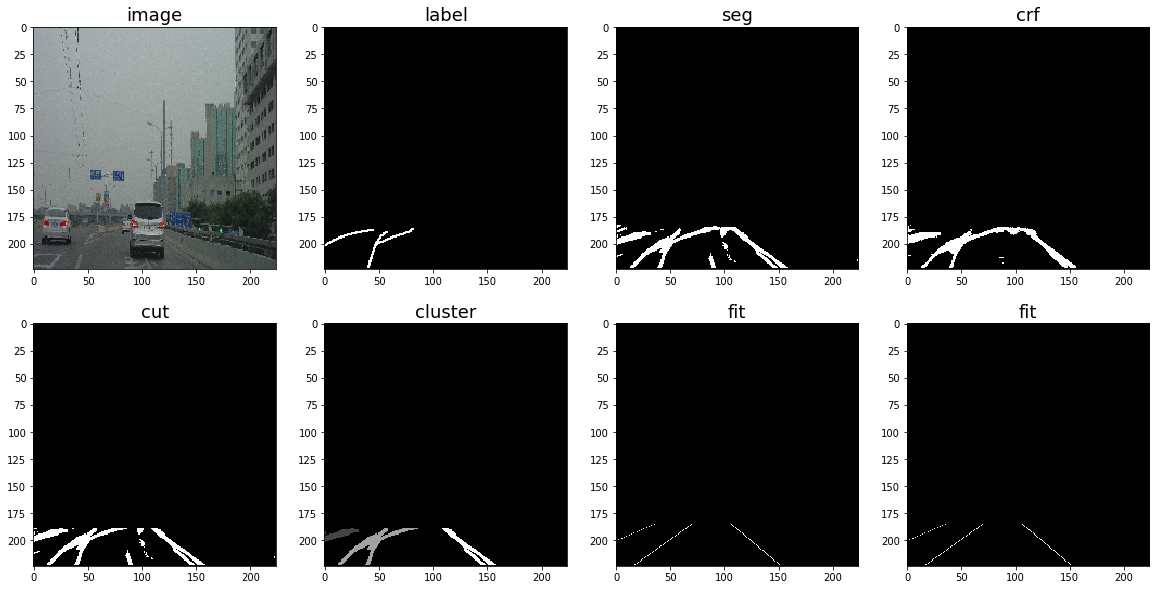

In [28]:
def show_test(CRF_GDIMS=(2,2), CRF_BDIMS=(20,20), CUT_TOP_THRESH=10, CUT_WIDTH=25, CUT_FRAC=0.75, 
              CLUSTER_EPS=1.9, CLUSTER_MINN=50, CLUSTER_RANGE=20, FIT_THETA=15, FIT_RO = 35, index=-1):
    if index == -1:
        test_index = random.randint(0, len(val_labels))
    else:
        test_index = index
    test_img = val_images[test_index]
    test_label = val_labels[test_index,:,:,1]
    test_seg = detect_points(test_img, model, DATA_SHAPE)
    test_crf = crf_image(test_img, model, gdims=CRF_GDIMS, bdims=CRF_BDIMS, iteras=1)
    test_cut, top_index = cut_top(test_seg, CUT_TOP_THRESH, frac=0.12)
    test_cut = cut_shit(test_cut, CUT_WIDTH, CUT_FRAC)
    test_point = matrix_to_point(test_cut)
    test_cluster = get_clusters(test_point, EPS = CLUSTER_EPS, MIN_SAMPLES = 3, minN = CLUSTER_MINN, RANGE = CLUSTER_RANGE)
#     for point in test_cluster[1]:
#         print(point)
    cluster_img = cluster_to_img(test_cluster, DATA_SHAPE)
    test_lines = get_better_line_per_sample(test_cluster, top_index, ANGEL=FIT_THETA, DIS=FIT_RO)
    lines_img = lines_to_img(test_lines, DATA_SHAPE)
    
    fig, axs = plt.subplots(2, 4, figsize=(20,10))
    axs[0,0].set_title('image', fontsize=18), axs[0,0].imshow(test_img) 
    axs[0,1].set_title('label', fontsize=18), axs[0,1].imshow(test_label, cmap='gray')
    axs[0,2].set_title('seg', fontsize=18), axs[0,2].imshow(test_seg,cmap='gray')
    axs[0,3].set_title('crf', fontsize=18), axs[0,3].imshow(test_crf,cmap='gray')
    axs[1,0].set_title('cut', fontsize=18), axs[1,0].imshow(test_cut,cmap='gray')
    axs[1,1].set_title('cluster', fontsize=18), axs[1,1].imshow(cluster_img, cmap='gray')
    axs[1,2].set_title('fit', fontsize=18), axs[1,2].imshow(lines_img, cmap='gray')
    axs[1,3].set_title('fit', fontsize=18), axs[1,3].imshow(lines_img, cmap='gray')
    print("index %s"%test_index, "cluster number %s"%len(test_cluster), "fit number %s"%len(test_lines), "top index %s"%top_index)
    plt.show()
    
CRF_GDIMS = (1,1)
CRF_BDIMS = (3,3)
CUT_TOP_THRESH = 8
CUT_WIDTH = 42
CUT_FRAC = 0.8
CLUSTER_EPS = 1.9
CLUSTER_MINN = 50
CLUSTER_RANGE = 27
FIT_THETA = 20
FIT_RO = 20
show_test(CRF_GDIMS, CRF_BDIMS, CUT_TOP_THRESH, CUT_WIDTH, CUT_FRAC, CLUSTER_EPS, CLUSTER_MINN, CLUSTER_RANGE, FIT_THETA, FIT_RO, )

# Save valid result

In [14]:
def get_cluster(image):
    crf = crf_image(image, model, gdims=CRF_GDIMS, bdims=CRF_BDIMS, iteras=1)
    cut, top_index = cut_top(crf, CUT_TOP_THRESH, frac=0.12)
    cut = cut_shit(cut, CUT_WIDTH, CUT_FRAC)
    point = matrix_to_point(cut)
    cluster = get_clusters(point, EPS = CLUSTER_EPS, MIN_SAMPLES = 3, minN = CLUSTER_MINN, RANGE = CLUSTER_RANGE)
    return cluster, top_index

def get_cluster_list(image_list):
    cluster_list = []
    for image in tqdm(image_list):
        cluster,_ = get_cluster(image)
        cluster_list.append(cluster)
    return cluster_list
    
def pipeline(image):
    cluster, top_index = get_cluster(image)
    lines = get_better_line_per_sample(cluster, top_index, ANGEL=FIT_THETA, DIS=FIT_RO)
    return lines

def pipeline_list(image_list):
    line_list = []
    for image in tqdm(image_list):
        lines = pipeline(image)
        line_list.append(lines)
    return line_list

def np2json(arlines):
    json_lines = []
    for arline in arlines:
        json_line = []
        for point in arline:
            json_line.append({"x":int(point[1]), "y":int(point[0])})
        json_lines.append(json_line)
    return {"Lanes": json_lines}

def save_jsons(lines_list, list_path, json_path):
    test_md5_paths = open(list_path, 'r').readlines()
    for i, lines in tqdm(enumerate(lines_list)):
        md5 = test_md5_paths[i].split('.')[0]
        lines_json = np2json(lines)
        lines_str = json.dumps(lines_json)
        file = open(json_path + '%s.json'%md5,'w')
        file.write(lines_str)
        file.close()
        
val_result = pipeline_list(val_images)
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_json_path = '/home/mc16/result_json/val_result_1/'
save_jsons(val_result, val_list_path, val_json_path)
#!python /home/mc16/evalue.py

100%|██████████| 2015/2015 [17:18<00:00,  1.94it/s]
2015it [00:01, 1980.50it/s]


In [15]:
!python /home/mc16/evalue.py

2015it [00:37, 53.75it/s]
{'f1': 0.615015523567598, 'code': 0, 'precision': 0.6813633520950594, 'recall': 0.5604423868312757}


In [8]:
# val_cluster_resutl = get_cluster_list(val_images)
# time = datetime.datetime.now().strftime(TIMEFORMAT)
# np.save('val_cluster_%s'%time, val_cluster_resutl)

100%|██████████| 2015/2015 [13:52<00:00,  2.42it/s]


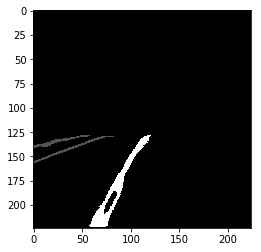

In [11]:
plt.imshow(cluster_to_img(val_cluster_resutl[1000], DATA_SHAPE), cmap='gray')
plt.show()

# Save test1 result

In [58]:
test1_result = pipeline_list(test1_images)
test_list_path = '/home/mc16/test1_list.txt'
test_json_path = '/home/mc16/result_json/results/'
save_jsons(test1_result, test_list_path, test_json_path)

100%|██████████| 2034/2034 [14:41<00:00,  2.31it/s]
2034it [00:01, 1336.18it/s]
